# Setting

In [48]:
from lbk_utils import save_csv, read_csv, SemanticSearch
from vivino_utils import vivino_reviews, concat_reviews, check_url, check_duplicated, find_style, simple_scraper, translate_reviews

import pandas as pd
import time

# Existing

In [2]:
!unzip -l wine_reviews.zip

Archive:  wine_reviews.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
  2316472  2024-03-27 12:50   wine_reviews_240327.csv
---------                     -------
  2316472                     1 file


In [2]:
file = 'wine_reviews_2' # exclude wine_reviews_tmp.csv
       
df_reviews = read_csv(file, 'data', parse_dates=['date'])
len(df_reviews)

9891

In [3]:
df_reviews.head()

,wid,wine,date,review,source,lang,review_transl,style
0,40,Arione Moscato d'Asti,2023-11-06,pera pesca nota tropicale minerali,vivino,it,pear peach tropical note minerals,sparkling
1,40,Arione Moscato d'Asti,2023-10-17,Ottimo,vivino,it,Optimal,sparkling
2,40,Arione Moscato d'Asti,2023-10-09,"조금 산뜻한 향, 처음 마시고 조금 있는 바디감, Saracco보다 조금 덜 달게 ...",vivino,ko,"A slightly refreshing scent, a bit of body whe...",sparkling
3,40,Arione Moscato d'Asti,2023-10-08,"Afrutado, delicioso.",vivino,es,"Fruity, delicious.",sparkling
4,40,Arione Moscato d'Asti,2023-07-21,honey apple peach citrus Slight fizziness ligh...,vivino,en,honey apple peach citrus Slight fizziness ligh...,sparkling


In [4]:
df_reviews.groupby(['wid', 'wine']).review_transl.count().sort_index(level=0)

wid  wine                                                   
0    Casillero del Diablo Cabernet Sauvignon (Reserva)          472
1    Yellow Tail Cabernet Sauvignon                             136
2    Roche Mazet Cuvée Spéciale Cabernet Sauvignon               61
3    San Pedro Gato Negro Cabernet Sauvignon                    878
4    Aguirre Dos Copas Cabernet Sauvignon                         7
                                                               ... 
64   Dark Horse Cabernet Sauvignon                              275
65   14 Hands Cabernet Sauvignon                                106
66   Quebrada de Macul Alba de Domus                             28
67   Montes Montes Alpha Special Cuvée Cabernet Sauvignon        37
68   Masseria Borgo dei Trulli Lucale Appassimento Primitivo     63
Name: review_transl, Length: 69, dtype: int64

In [5]:
df_reviews.wid.nunique()

69

In [6]:
id_start = df_reviews.wid.max() + 1
id_start

69

In [7]:
# wid missing
mwid = set(range(df_reviews.wid.max())) - set(df_reviews.wid.unique())
mwid = list(mwid)
mwid

[]

## Check duplicates

In [9]:
check_duplicated(df_reviews)

,wid,wine,date,review,source,lang,review_transl,style


*uncomment if duplicates exist*

In [11]:
#df_reviews = check_duplicated(df_reviews, drop=True)

In [12]:
len(df_reviews)

9891

# Scraping

## Wines

In [11]:
url = 'https://www.gsshop.com/shop/wine/plan.gs?planSeq=175966&planType=R&lseq=424328-5'
wines, _ = simple_scraper(url, 'prd-name', 'prd-desc')

In [12]:
ws = dict(zip(wines['prd-name'], wines['prd-desc']))
ws

{'몬테스)알파 블랙 카버네소비뇽': 'Montes Alpha Black C/S',
 '카니버 카버네 소비뇽': 'CARNIVOR CABERNET SAUVIGNON',
 '킬리카눈 코브넌트 쉬라즈': 'KILIKANOON COVENANT SHIRAZ',
 '투 핸즈)엔젤스 쉐어 쉬라즈': "Two Hands Angel's Share",
 '디아블로)블랙 카베르네 소비뇽': 'DIABLO BLACK CABERNET SAUVIGNON',
 '카를로 사니 수수마니엘로': 'Carlo Sani, Susumaniello',
 '다렌버그 하이 트렐리스 카베르네 소비뇽': 'The High Trellis Cabernet Sauvignon',
 '보데가스 란 그란 리제르바': 'BODEGAS LAN GRAN RESERVA',
 '포스타 레드와인(2입)': 'Four Star Red',
 '우드브릿지 까베르네 소비뇽': 'Woodbridge Cabernet Sauvignon',
 '까테나 자파타)까테나 까베르네소비뇽': 'Catena Zapata Catena Cabernet Sauvignon',
 '우나니메)피노누아': 'UNANIME PINOT NOIR',
 '끌로 드 로스 씨에떼': 'Clos de Los Siete',
 '필리프 수퍼 토스카나(피크닉 와인)': 'Philip (Super Toscana)',
 '라포스톨)그랑 셀렉션 메를로': 'Lapostolle Merlot',
 '델리카토)1924 포트 배럴 에이지드 피노누아': '1924 Port Barrel Aged Pinot Noir',
 '코폴라)다이아컬렉션 클라렛': 'Coppola-Diamond Collection Claret',
 '다크호스 카버네 소비뇽': 'DARK HORSE CABERNET SAUVIGNON',
 '14 핸즈 카베르네 소비뇽': '14Hands Cabernet Sauvignon',
 '알바 드 도머스': 'Alba de Domus',
 '파이오니어스 포인트 까베르네 소비뇽': "Pion

In [16]:
ws['몬테스)알파 블랙 카버네소비뇽'] = 'Montes Montes Alpha Special Cuvée Cabernet Sauvignon'
ws['루칼레 아파씨멘토'] = 'Lucale Appassimento'
ws

{'몬테스)알파 블랙 카버네소비뇽': 'Montes Montes Alpha Special Cuvée Cabernet Sauvignon',
 '카니버 카버네 소비뇽': 'CARNIVOR CABERNET SAUVIGNON',
 '킬리카눈 코브넌트 쉬라즈': 'KILIKANOON COVENANT SHIRAZ',
 '투 핸즈)엔젤스 쉐어 쉬라즈': "Two Hands Angel's Share",
 '디아블로)블랙 카베르네 소비뇽': 'DIABLO BLACK CABERNET SAUVIGNON',
 '카를로 사니 수수마니엘로': 'Carlo Sani, Susumaniello',
 '다렌버그 하이 트렐리스 카베르네 소비뇽': 'The High Trellis Cabernet Sauvignon',
 '보데가스 란 그란 리제르바': 'BODEGAS LAN GRAN RESERVA',
 '포스타 레드와인(2입)': 'Four Star Red',
 '우드브릿지 까베르네 소비뇽': 'Woodbridge Cabernet Sauvignon',
 '까테나 자파타)까테나 까베르네소비뇽': 'Catena Zapata Catena Cabernet Sauvignon',
 '우나니메)피노누아': 'UNANIME PINOT NOIR',
 '끌로 드 로스 씨에떼': 'Clos de Los Siete',
 '필리프 수퍼 토스카나(피크닉 와인)': 'Philip (Super Toscana)',
 '라포스톨)그랑 셀렉션 메를로': 'Lapostolle Merlot',
 '델리카토)1924 포트 배럴 에이지드 피노누아': '1924 Port Barrel Aged Pinot Noir',
 '코폴라)다이아컬렉션 클라렛': 'Coppola-Diamond Collection Claret',
 '다크호스 카버네 소비뇽': 'DARK HORSE CABERNET SAUVIGNON',
 '14 핸즈 카베르네 소비뇽': '14Hands Cabernet Sauvignon',
 '알바 드 도머스': 'Alba de Domus',

*search wines not in existing review data*

In [13]:
threshold=0
return_new=False # set to True if returning wines not in review db

# existing wines in data
wid_wine = df_reviews.drop_duplicates(['wid', 'wine'])[['wid', 'wine']].to_dict(orient='list')

vocabulary = wid_wine['wine'] # voca of existing wines
queries = list(ws.values()) # wines to search

wdb = SemanticSearch(vocabulary, embedding_model='all-MiniLM-L6-v2')
df = wdb.check_existence(queries, threshold=threshold, return_new=return_new, print_out=True)

model.safetensors: 100%|███████████████████████████████████████| 90.9M/90.9M [00:07<00:00, 11.6MB/s]


Existing words (query: result)
0: KILIKANOON COVENANT SHIRAZ / Kilikanoon Covenant Shiraz / 1.0
1: DIABLO BLACK CABERNET SAUVIGNON / Diablo Black Cabernet Sauvignon / 1.0
2: DARK HORSE CABERNET SAUVIGNON / Dark Horse Cabernet Sauvignon / 1.0
3: CARNIVOR CABERNET SAUVIGNON / Carnivor Cabernet Sauvignon / 1.0
4: Carlo Sani, Susumaniello / Carlo Sani Susumaniello / 0.958
5: 14Hands Cabernet Sauvignon / 14 Hands Cabernet Sauvignon / 0.939
6: Catena Zapata Catena Cabernet Sauvignon / Catena Cabernet Sauvignon / 0.913
7: The High Trellis Cabernet Sauvignon / d'Arenberg The High Trellis Cabernet Sauvignon / 0.905
8: Woodbridge Cabernet Sauvignon / Woodbridge by Robert Mondavi Cabernet Sauvignon / 0.895
9: 1924 Port Barrel Aged Pinot Noir / 1924 Wines Port Barrel Aged Pinot Noir (Limited Edition) / 0.884
10: Clos de Los Siete / Clos de los Siete Clos de Los Siete (by Michel Rolland) / 0.85
11: Alba de Domus / Quebrada de Macul Alba de Domus / 0.841
12: Pioneer's Point Cabernet Sauvignon / Kend

In [14]:
#idx = [1, 4, 10]
#df = df.loc[df.index.isin(idx)]
df

,query,result,score
0,KILIKANOON COVENANT SHIRAZ,Kilikanoon Covenant Shiraz,1.000
1,DIABLO BLACK CABERNET SAUVIGNON,Diablo Black Cabernet Sauvignon,1.000
2,DARK HORSE CABERNET SAUVIGNON,Dark Horse Cabernet Sauvignon,1.000
3,CARNIVOR CABERNET SAUVIGNON,Carnivor Cabernet Sauvignon,1.000
4,"Carlo Sani, Susumaniello",Carlo Sani Susumaniello,0.958
5,14Hands Cabernet Sauvignon,14 Hands Cabernet Sauvignon,0.939
6,Catena Zapata Catena Cabernet Sauvignon,Catena Cabernet Sauvignon,0.913
7,The High Trellis Cabernet Sauvignon,d'Arenberg The High Trellis Cabernet Sauvignon,0.905
8,Woodbridge Cabernet Sauvignon,Woodbridge by Robert Mondavi Cabernet Sauvignon,0.895
9,1924 Port Barrel Aged Pinot Noir,1924 Wines Port Barrel Aged Pinot Noir (Limite...,0.884


In [24]:
df.loc[~df.index.isin([13,16,22]), 'result'].to_list()

['Montes Montes Alpha Special Cuvée Cabernet Sauvignon',
 'Dark Horse Cabernet Sauvignon',
 'Kilikanoon Covenant Shiraz',
 'Diablo Black Cabernet Sauvignon',
 'Carnivor Cabernet Sauvignon',
 'Carlo Sani Susumaniello',
 '14 Hands Cabernet Sauvignon',
 'Catena Cabernet Sauvignon',
 "d'Arenberg The High Trellis Cabernet Sauvignon",
 'Woodbridge by Robert Mondavi Cabernet Sauvignon',
 '1924 Wines Port Barrel Aged Pinot Noir (Limited Edition)',
 'Clos de los Siete Clos de Los Siete (by Michel Rolland)',
 'Quebrada de Macul Alba de Domus',
 'Lapostolle Grand Selection Merlot',
 'Lan Gran Reserva Rioja',
 "Two Hands Angels' Share Shiraz",
 'Francis Ford Coppola Winery Diamond Collection Claret',
 'Mazzei Philip',
 'Masseria Borgo dei Trulli Lucale Appassimento Primitivo',
 'Volver Tarima Hill Old Vines Monastrell']

In [15]:
q = df['query'].tolist()
_ = wdb.check_existence(q, threshold=0)

Existing words (query: result)
0: KILIKANOON COVENANT SHIRAZ / Kilikanoon Covenant Shiraz / 1.0
1: DIABLO BLACK CABERNET SAUVIGNON / Diablo Black Cabernet Sauvignon / 1.0
2: DARK HORSE CABERNET SAUVIGNON / Dark Horse Cabernet Sauvignon / 1.0
3: CARNIVOR CABERNET SAUVIGNON / Carnivor Cabernet Sauvignon / 1.0
4: Carlo Sani, Susumaniello / Carlo Sani Susumaniello / 0.958
5: 14Hands Cabernet Sauvignon / 14 Hands Cabernet Sauvignon / 0.939
6: Catena Zapata Catena Cabernet Sauvignon / Catena Cabernet Sauvignon / 0.913
7: The High Trellis Cabernet Sauvignon / d'Arenberg The High Trellis Cabernet Sauvignon / 0.905
8: Woodbridge Cabernet Sauvignon / Woodbridge by Robert Mondavi Cabernet Sauvignon / 0.895
9: 1924 Port Barrel Aged Pinot Noir / 1924 Wines Port Barrel Aged Pinot Noir (Limited Edition) / 0.884
10: Clos de Los Siete / Clos de los Siete Clos de Los Siete (by Michel Rolland) / 0.85
11: Alba de Domus / Quebrada de Macul Alba de Domus / 0.841
12: Pioneer's Point Cabernet Sauvignon / Kend

In [22]:
_ = [print(x) for x in q]

Pioneer's Point Cabernet Sauvignon
UNANIME PINOT NOIR
Four Star Red


In [16]:
q = ['Mascota Vineyards Unánime Pinot Noir']
_ = wdb.check_existence(q, threshold=0)

Existing words (query: result)
0: Mascota Vineyards Unánime Pinot Noir / Mascota Vineyards Unánime Pinot Noir / 1.0

Returning new words


*keep log of wine scraping*

In [24]:
df = read_csv('wine_log.txt', parse_dates=['date'])
df

,date,wine,comment,source
0,2024-03-27,Four Star Red,no recent reviews in vivino,vivino
1,2024-03-27,Pioneer's Point Cabernet Sauvignon,not enough ratings in vivino,vivino
2,2024-03-27,Mascota Vineyards Unánime Pinot Noir,fail to find in review db as UNANIME PINOT NOIR,NaN


### Check URL

In [16]:
file = 'data/wines_to_collect.txt'

with open(file, 'r') as f:
    w = f.read()
print(w)

Four Star Red
https://www.vivino.com/US-CA/en/four-star-red/w/4235576?ref=nav-search
Arione Moscato d'Asti
https://www.vivino.com/arione-moscato-d-asti/w/1154484?ref=nav-search
Catena Cabernet Sauvignon
https://www.vivino.com/catena-mendoza-cabernet-sauvignon/w/1268655?ref=nav-search


In [17]:
w = w.strip('\n').split('\n')
wines = {w[i]:w[i+1] for i in range(0, len(w), 2)}
len(wines)

3

In [18]:
# check if wine name and its url match or not
df = check_url(wines)

The top 5 pairs of least similarity:
0.85) Arione Moscato d'Asti: arione-moscato-d-asti
0.89) Catena Cabernet Sauvignon: catena-mendoza-cabernet-sauvignon
0.92) Four Star Red: four-star-red


## Setting

In [11]:
locator_ratings = "//a[@href='#all_reviews']"
locator_more = "//button[@tabindex='0']"
locator_recent = '//*[@data-testid="baseModalBackdrop"]/div[2]/div[2]/div[2]/div/a[1]'

locator_review = "communityReview__reviewText--2bfLj"
locator_date = "anchor_anchor__m8Qi- reviewAnchor__anchor--2NKFw reviewDate__reviewDate--49vpM undefined"

kwargs = {
    'loc1': locator_ratings,
    'loc2': locator_more,
    'loc3': locator_recent, 
    'loc4': locator_review,
    'loc5': locator_date
}

In [12]:
kwargs.update({
    'end_date': '20220101',
    'source': 'vivino',
    #'headless': True, # failed for background running 
    #'max_scr': 10, 'time_scr': 2, 'check_idx': 4
})

## Collect

*load reviews of wines not translated yet*

In [24]:
#file = 'wine_\d+\.csv'
file = 'wine_8'

df_reviews = pd.DataFrame()

df = read_csv(file, 'data', parse_dates=['date'])
df_reviews = pd.concat([df_reviews, df])

# check duplicate wid
df_reviews.groupby('wid').wine.unique()

wid
8    [Viña Santa Helena Reservado Cabernet Sauvignon']
Name: wine, dtype: object

In [25]:
id_start = df_reviews.wid.max() + 1
id_start

9

*uncomment if no reviews unfinished*

In [19]:
df_reviews = pd.DataFrame()

In [20]:
num_try = 1 # num of try to scrape for failed wines

col_rev = ['wid', 'wine', 'date', 'review', 'source']
path = 'data'
wines_failed = dict()

for i in range(num_try):
    print(f'scraping {i+1}', '*'*20)
    #for wine_name, wine_url in wines:
    for wine_name, wine_url in wines.items():
        try:
            df = vivino_reviews(wine_url, wine_name, **kwargs)
            df_reviews = concat_reviews(df_reviews, df, wine_name, col_rev, path=path, id_start=id_start)
        except:
            print(f'ERROR: check {wine_name}')
            wines_failed.update({wine_name: wine_url})
        time.sleep(3)

    if len(wines_failed) > 0:
        print(f'num of failed: {len(wines_failed)}\n')
        wines = wines_failed
        wines_failed = dict()
        time.sleep(3)
    else:
        break

scraping 1 ********************
ERROR) Check locator: //*[@data-testid="baseModalBackdrop"]/div[2]/div[2]/div[2]/div/a[1]
ERROR: check Four Star Red


33it [00:16,  2.01it/s]


Arione Moscato d'Asti: 33 reviews collected.
data/wine_69.csv saved.


123it [01:43,  1.18it/s]


Catena Cabernet Sauvignon: 123 reviews collected.
data/wine_70.csv saved.
num of failed: 1



**temp saving before translation**

In [23]:
df_reviews.groupby(['wid', 'wine']).review.count().sort_index(level=0)

wid  wine                     
69   Arione Moscato d'Asti         33
70   Catena Cabernet Sauvignon    123
Name: review, dtype: int64

In [24]:
save_csv(df_reviews, 'wine_reviews_tmp.csv', 'data', overwrite=True)

data/wine_reviews_tmp.csv saved.


# Review data

In [29]:
df_reviews = read_csv('wine_reviews_tmp.csv', 'data', parse_dates=['date'])

In [30]:
cond = (df_reviews.date.isna()) | (df_reviews.review.isna())
df_reviews.loc[cond]

,wid,wine,date,review,source
29,69,Arione Moscato d'Asti,2021-10-30,NaN,vivino
100,70,Catena Cabernet Sauvignon,2022-06-27,NaN,vivino
123,70,Catena Cabernet Sauvignon,2022-01-27,NaN,vivino
146,70,Catena Cabernet Sauvignon,2021-11-12,NaN,vivino
153,70,Catena Cabernet Sauvignon,2016-06-10,NaN,vivino


In [31]:
df_reviews = df_reviews.loc[~cond].reset_index(drop=True)

In [32]:
df_reviews.date.dt.year.value_counts().sort_index(ascending=False)

date
2024    12
2023    42
2022    70
2021    24
2020     2
2018     1
Name: count, dtype: int64

In [33]:
kwargs['end_date']

'20220101'

In [34]:
df_reviews = df_reviews.loc[df_reviews.date >= kwargs['end_date']]

<Axes: >

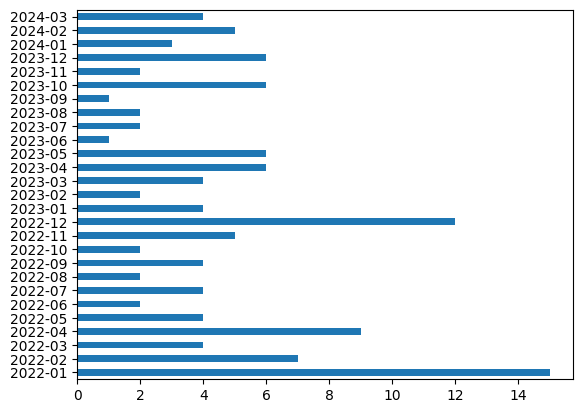

In [35]:
#d = df_reviews.date.agg(['min', 'max']).to_list()
d = [kwargs['end_date'], df_reviews.date.max()]

date_range = pd.date_range(start=d[0], end=d[1]).to_period("M").unique()

(df_reviews
 .set_index('date').to_period("M")
 .groupby(level=0).review.count()
 .sort_index()
 .reindex(date_range, fill_value=0)
 .plot(kind='barh')
)

<Axes: ylabel='wine'>

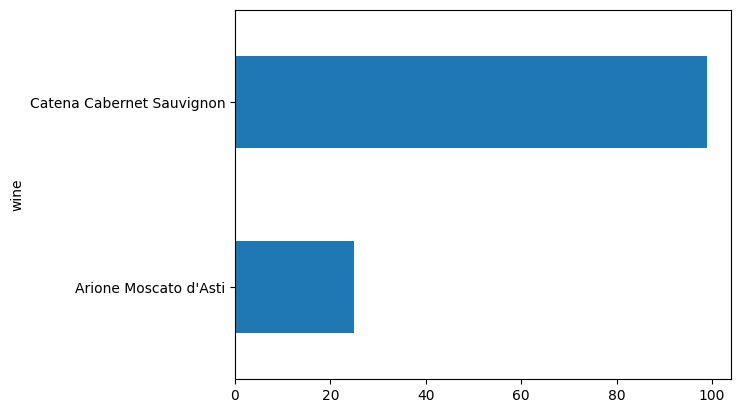

In [36]:
(df_reviews
 .groupby(by='wine').review.count()
 .plot(kind='barh')
)

In [75]:
df_reviews.head()

,wid,wine,date,review,source
0,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2024-03-14,"Vinho muito, mas muito bom da excelente vinícu...",vivino
1,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2024-01-20,oak tobacco black fruit blackberry pepper smok...,vivino
2,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2024-01-11,Adoramos! Frutas vermelhas. Ameixa. Pimentão v...,vivino
3,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2023-12-17,Boda en SMA Clau y Polo,vivino
4,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2023-12-02,Gedronken bij Marcel en Marius. Qua smaakprofi...,vivino


[Check duplicates](#Check-duplicates)

## Wine ID

In [79]:
df_reviews

,wid,wine,date,review,source
0,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2024-03-14,"Vinho muito, mas muito bom da excelente vinícu...",vivino
1,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2024-01-20,oak tobacco black fruit blackberry pepper smok...,vivino
2,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2024-01-11,Adoramos! Frutas vermelhas. Ameixa. Pimentão v...,vivino
3,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2023-12-17,Boda en SMA Clau y Polo,vivino
4,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2023-12-02,Gedronken bij Marcel en Marius. Qua smaakprofi...,vivino
...,...,...,...,...,...
181,69,Volver Tarima Hill Old Vines Monastrell,2022-01-20,"Vino espectacular, 14 meses en barrica frances...",vivino
182,69,Volver Tarima Hill Old Vines Monastrell,2022-01-15,"Dry, Dark, Bold with great flavor",vivino
183,69,Volver Tarima Hill Old Vines Monastrell,2022-01-10,Muy bueno,vivino
184,69,Volver Tarima Hill Old Vines Monastrell,2022-01-10,A very flavorful wine it also has a very nice ...,vivino


In [37]:
file = 'wine_reviews_2' # exclude wine_reviews_tmp.csv
df_reviews_db = read_csv(file, 'data', parse_dates=['date'])
len(df_reviews_db)

9891

In [81]:
set(range(df_reviews_db.wid.max()+1)) - set(df_reviews_db.wid.unique())

{41}

In [82]:
wid_f, wid_t = 69, 41

In [83]:
df_reviews.loc[df_reviews.wid == wid_f, 'wid'] = wid_t

In [84]:
df_reviews.groupby('wid').wine.count()

wid
41    73
67    37
68    63
Name: wine, dtype: int64

In [89]:
file_f = f'wine_{wid_f}.csv'
df = read_csv(file_f, 'data', parse_dates=['date'])
df['wid'] = wid_t

# TODO: update with new function name
save_csv(df, f'wine_{wid_t}.csv', 'data')

data/wine_41.csv saved.


In [91]:
!rm data/{file_f}

## Wine style

In [38]:
len(df_reviews)

124

In [39]:
df_reviews.head()

,wid,wine,date,review,source
0,69,Arione Moscato d'Asti,2024-02-16,Plus pétillant que le Canelli,vivino
1,69,Arione Moscato d'Asti,2023-11-06,pera pesca nota tropicale minerali,vivino
2,69,Arione Moscato d'Asti,2023-10-17,Ottimo,vivino
3,69,Arione Moscato d'Asti,2023-10-09,"조금 산뜻한 향, 처음 마시고 조금 있는 바디감, Saracco보다 조금 덜 달게 ...",vivino
4,69,Arione Moscato d'Asti,2023-10-08,"Afrutado, delicioso.",vivino


In [40]:
#df_reviews.nunique()
df_reviews[['wid','wine','style']].drop_duplicates().groupby('style').wid.count()

KeyError: "['style'] not in index"

In [41]:
wid_wine = df_reviews[['wid', 'wine']].drop_duplicates().to_dict(orient='list')
wid_wine['wine']

["Arione Moscato d'Asti", 'Catena Cabernet Sauvignon']

In [42]:
wines =  wid_wine['wine']
df_style = find_style(wines)

In [43]:
#s = 'sparkling'
s = 'red'
#s = 'white'
#WINE_STYLE[s]

thr = 0.

cond = (df_style['style'] == s)
cond = cond & (df_style['score'] >= thr)
df_style.loc[cond].sort_values('score', ascending=False)

,wine,style,score,word
1,Catena Cabernet Sauvignon,red,0.905312,cabernet sauvignon


In [50]:
#idx = [54,58,67,57]
idx = [40] # sparkling
df_style.loc[idx, ['style','word']] = ['white', 'manual']
df_style.loc[cond]

,wine,style,score,word
1,Two Hands Angels' Share Shiraz,red,0.608343,shiraz
2,Two Hands Gnarly Dudes Shiraz,red,0.692881,shiraz
3,Two Hands Sexy Beast Cabernet Sauvignon,red,0.817742,cabernet sauvignon
4,Cono Sur Single Vineyard Syrah,red,0.414768,syrah
5,Cono Sur Single Vineyard Cabernet Sauvignon,red,0.797582,cabernet sauvignon
6,Cono Sur Single Vineyard Pinot Noir,red,0.716799,pinot noir
7,Cono Sur Single Vineyard Carmenere,red,0.590391,carmenere
9,Montes Montes Alpha Merlot,red,0.568740,merlot
10,Montes Montes Alpha Syrah,red,0.453137,syrah
11,San Pedro 1865 Selected Vineyards Syrah,red,0.355353,syrah


In [51]:
# testing
#df_reviews = df_reviews.drop(columns=['style', 'score', 'word'])
df_reviews = df_reviews.drop(columns=['style'])

In [52]:
#df_reviews['style'] = df_reviews.apply(lambda x: wine_style[x.wine], axis=1)
df_reviews = df_reviews.join(df_style.set_index('wine')['style'], how='left', on='wine')
df_reviews.head()

,wid,wine,date,review,source,lang,review_transl,style
0,40,Arione Moscato d'Asti,2023-11-06,pera pesca nota tropicale minerali,vivino,it,pear peach tropical note minerals,sparkling
1,40,Arione Moscato d'Asti,2023-10-17,Ottimo,vivino,it,Optimal,sparkling
2,40,Arione Moscato d'Asti,2023-10-09,"조금 산뜻한 향, 처음 마시고 조금 있는 바디감, Saracco보다 조금 덜 달게 ...",vivino,ko,"A slightly refreshing scent, a bit of body whe...",sparkling
3,40,Arione Moscato d'Asti,2023-10-08,"Afrutado, delicioso.",vivino,es,"Fruity, delicious.",sparkling
4,40,Arione Moscato d'Asti,2023-07-21,honey apple peach citrus Slight fizziness ligh...,vivino,en,honey apple peach citrus Slight fizziness ligh...,sparkling


In [81]:
df_reviews.loc[df_reviews.wine.str.contains('Bianco')].head()

,wid,wine,date,review,source,lang,review_transl,style
6086,31,Villa M Bianco,2024-01-08,달달하니 맛있다,vivino,ko,It's sweet and delicious,white
6087,31,Villa M Bianco,2023-12-24,달달 그 잡채 넘넘 맛있당~~~~~~!!!>ㅁ< @짝꿍이네집 앞 GS편의점 2023.11,vivino,ko,That sweet japchae is so delicious~~~~~~!!!>ㅁ<...,white
6088,31,Villa M Bianco,2023-06-27,달달한 와인 가격대비는 아직 잘 모르겠다,vivino,ko,I'm still not sure about the price of sweet wine.,white
6089,31,Villa M Bianco,2023-04-29,sweet desert wine,vivino,af,sweet desert wine,white
6090,31,Villa M Bianco,2023-03-14,좀 달달하지만 짠 대게랑 마시니 너무 맛남!! 해산물과 먹어야쥐,vivino,ko,"It's a bit sweet, but it's so delicious when y...",white


# Translate

In [44]:
len(df_reviews)

124

In [45]:
df_reviews.head()

,wid,wine,date,review,source
0,69,Arione Moscato d'Asti,2024-02-16,Plus pétillant que le Canelli,vivino
1,69,Arione Moscato d'Asti,2023-11-06,pera pesca nota tropicale minerali,vivino
2,69,Arione Moscato d'Asti,2023-10-17,Ottimo,vivino
3,69,Arione Moscato d'Asti,2023-10-09,"조금 산뜻한 향, 처음 마시고 조금 있는 바디감, Saracco보다 조금 덜 달게 ...",vivino
4,69,Arione Moscato d'Asti,2023-10-08,"Afrutado, delicioso.",vivino


In [ ]:
df_reviews = translate_reviews(df_reviews)  
df_reviews.head()

**check translation error**

In [95]:
cond = df_reviews.lang.str.contains('ERROR')
df_reviews.loc[cond]

,wid,wine,date,review,source,lang,review_transl


In [ ]:
df_err = df_reviews.loc[cond].drop(columns=['lang', 'review_transl'])
df_err = translate_reviews(df_err, merge=True)  
df_err

In [76]:
cond_err = df_err.index.isin([1,8,10])
df_err.loc[cond_err]

,wid,wine,date,review,source,lang,review_transl
1,52,Diablo Black Cabernet Sauvignon,2023-06-27,👍,vivino,<-- ERROR -->,None
8,56,Woodbridge by Robert Mondavi Cabernet Sauvignon,2022-11-20,Luísa,vivino,ca,Luisa
10,56,Woodbridge by Robert Mondavi Cabernet Sauvignon,2022-07-17,B2,vivino,de,B2


In [82]:
df_reviews = pd.concat([df_reviews.loc[~cond], df_err.loc[~cond_err]]).reset_index(drop=True)

In [64]:
cond = df_reviews.review_transl.isna()
df_reviews.loc[cond]

,wid,wine,date,review,source,lang,review_transl


In [65]:
df_reviews = df_reviews.loc[~cond]

# save

In [25]:
file = 'wine_reviews'
zfile = f'{file}.zip'

In [26]:
!unzip -l {zfile}

Archive:  wine_reviews.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
  2316472  2024-03-27 12:50   data/wine_reviews_240327.csv
---------                     -------
  2316472                     1 file


In [27]:
from datetime import datetime
d = datetime.today().strftime('%y%m%d')
#d = f'{d}b'

cfile = f'{file}_{d}.csv'
save_csv(df_reviews, cfile)

ERROR: data/wine_reviews_240327.csv already exists


In [28]:
!zip -uj {zfile} data/{cfile}
#!zip -uj wine_reviews.zip data/wine_reviews_2*e.csv

	zip warning: wine_reviews.zip not found or empty
  adding: wine_reviews_240327.csv (deflated 72%)


In [29]:
!unzip -l {zfile}

Archive:  wine_reviews.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
  2316472  2024-03-27 12:50   wine_reviews_240327.csv
---------                     -------
  2316472                     1 file


In [ ]:
import re

pattern = r"'wine_\d+\.csv'"

# Find matches
matches = [s for s in data if re.match(pattern, s)]

In [31]:
import os

path = 'data'
#files = [x for x in os.listdir(path) if x.startswith(file)]
files = [x for x in os.listdir(path)]

In [44]:
files

import re
pattern = r'wine_\d+\.csv'
pattern = 'wine_reviews_2'

[s for s in files if re.match(pattern, s)]

['wine_reviews_240327.csv']

In [41]:
re.match(pattern, 'wine_55.csv')

<re.Match object; span=(0, 11), match='wine_55.csv'>